In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.boston_housing.load_data()

In [3]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

xtrain = tf.cast(xtrain, dtype=tf.float32)
xtest = tf.cast(xtest, dtype=tf.float32)
ytrain = tf.cast(ytrain, dtype=tf.float32)
ytest = tf.cast(ytest, dtype=tf.float32)


In [4]:
def load_array(features, batch_size, is_train = True):
    data = tf.data.Dataset.from_tensor_slices(features)
    data = data.shuffle(buffer_size = 1000)
    data = data.batch(batch_size)
    return data

def init_params():
    """ Initialize w, b"""
    w = tf.Variable(tf.random.normal(shape = (xtrain.shape[1], 1), mean = 0, stddev= 0.1), trainable = True)
    b = tf.Variable(tf.zeros(1), trainable = True)
    return w, b

def lin_reg(X, w, b):
    """ Linear Regression : y = wx + b """
    return tf.matmul(X, w) + b

def squared_loss(yhat, y):
    return (yhat - tf.reshape(y, yhat.shape))**2/2

def sgd_adam(params, states, momentums, grads, eta, batch_size):
    beta1, beta2, eps = 0.9, 0.99, 1e-6
    for param, state, momentum, grad in zip(params, states, momentums, grads):
            momentum[:].assign(beta1 * momentum + (1 - beta1)*grad)
            state[:].assign(beta2 * state + (1 - beta2)*tf.math.square(grad))
            
            mom_bias_correction = momentum/(1 - beta1)
            state_bias_correction = state/(1 - beta2)

            param[:].assign(param - eta*mom_bias_correction/tf.math.sqrt(state_bias_correction + eps))

def init_adam(features_dim):
    s_w = tf.Variable(tf.zeros((features_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    v_w = tf.Variable(tf.zeros((features_dim, 1)))
    v_b = tf.Variable(tf.zeros(1))
    return ((s_w, s_b), (v_w, v_b))

In [5]:
eta = 0.03
momentum = 0.9
num_epochs = 100
batch_size = 32

w, b = init_params()
training_loss = []
for epoch in range(num_epochs):
    for X, y in load_array((xtrain, ytrain), batch_size):
        X, y = tf.cast(X, dtype=tf.float32), tf.cast(y, dtype=tf.float32)
        with tf.GradientTape() as tape:
            # Do forward prop & Compute loss
            yhat = lin_reg(X, w, b)
            loss = squared_loss(yhat, y)

        # Compute Gradient
        dw, db = tape.gradient(loss, [w, b])

        # Update w, b with adam
        (s_w, s_b), (v_w, v_b) = init_adam(xtrain.shape[1])
        sgd_adam([w, b], [s_w, s_b], [v_w, v_b], [dw, db],  eta, batch_size)

    epoch_loss = np.round(tf.reduce_mean(squared_loss(lin_reg(xtrain, w, b), ytrain)), 2)
    training_loss.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"epoch : {epoch}, training_loss : {epoch_loss}")

epoch : 0, training_loss : 272.7300109863281
epoch : 10, training_loss : 179.66000366210938
epoch : 20, training_loss : 113.33000183105469
epoch : 30, training_loss : 64.9000015258789
epoch : 40, training_loss : 32.459999084472656
epoch : 50, training_loss : 14.640000343322754
epoch : 60, training_loss : 11.430000305175781
epoch : 70, training_loss : 11.1899995803833
epoch : 80, training_loss : 11.239999771118164
epoch : 90, training_loss : 11.199999809265137


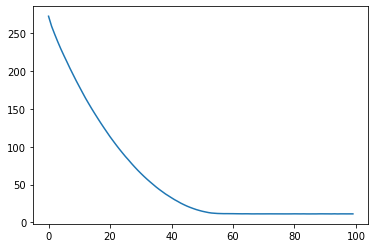

In [6]:
plt.plot(np.arange(num_epochs), training_loss)